In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from scipy.stats import chi2_contingency
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data = pd.read_csv("mpg.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [3]:
# 9 columns with 398 rows, each column has 398 entries that are not Null
print(data.dtypes) # all columnes despite horsepower and name are numeric so no missing hardcoded values
print(data["name"].unique()) # name seems to have only valid entries
print(data["horsepower"].unique()) # all int values but one ? as entry => missing data

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model_year        int64
origin            int64
name             object
dtype: object
['chevrolet chevelle malibu' 'buick skylark 320' 'plymouth satellite'
 'amc rebel sst' 'ford torino' 'ford galaxie 500' 'chevrolet impala'
 'plymouth fury iii' 'pontiac catalina' 'amc ambassador dpl'
 'dodge challenger se' "plymouth 'cuda 340" 'chevrolet monte carlo'
 'buick estate wagon (sw)' 'toyota corona mark ii' 'plymouth duster'
 'amc hornet' 'ford maverick' 'datsun pl510'
 'volkswagen 1131 deluxe sedan' 'peugeot 504' 'audi 100 ls' 'saab 99e'
 'bmw 2002' 'amc gremlin' 'ford f250' 'chevy c20' 'dodge d200' 'hi 1200d'
 'chevrolet vega 2300' 'toyota corona' 'ford pinto'
 'plymouth satellite custom' 'ford torino 500' 'amc matador'
 'pontiac catalina brougham' 'dodge monaco (sw)'
 'ford country squire (sw)' 'pontiac safari (sw)'
 'amc hornet sportabout (sw)' '

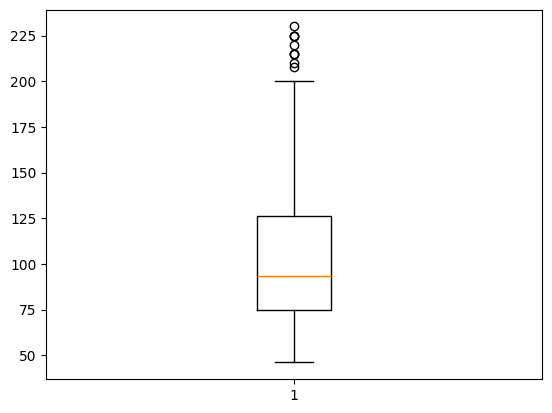

In [4]:
data_horsepower = pd.to_numeric(data[data["horsepower"] != "?"]["horsepower"]) # drop all columns with ? as entry
plt.boxplot(data_horsepower)
plt.show()

In [5]:
# ? entries have to be replaced, as seen in the boxplot there are some outliers so take median and not mean as replacment for increased robustness
data["horsepower"] = pd.to_numeric(data["horsepower"].replace(to_replace="?", value=np.median(data_horsepower)))

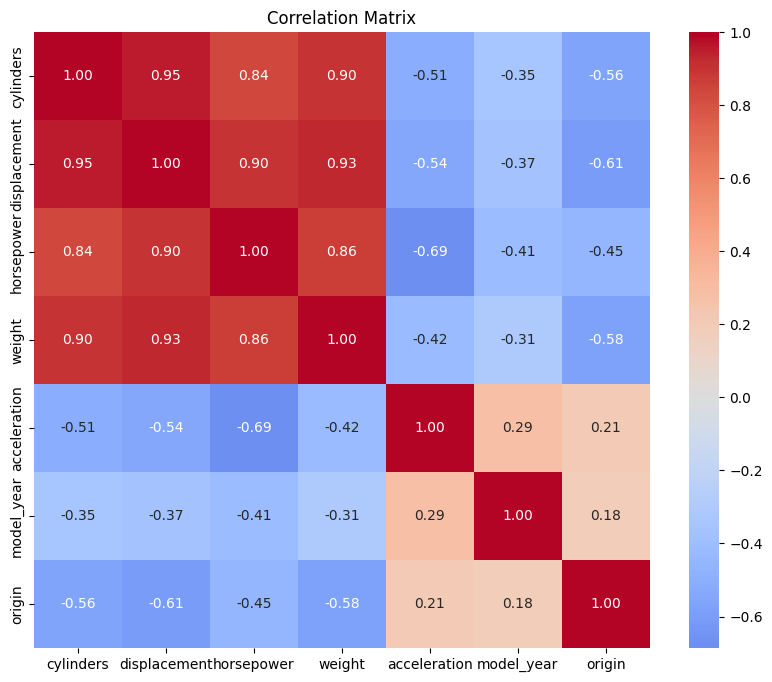

In [6]:
# dont use name since 305 distinct values and we would have to make one hot encoding
X_numeric = data.drop(["name", "mpg"], axis=1)
y = data["mpg"]
corr_matrix = X_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Correlation Matrix")
plt.show()

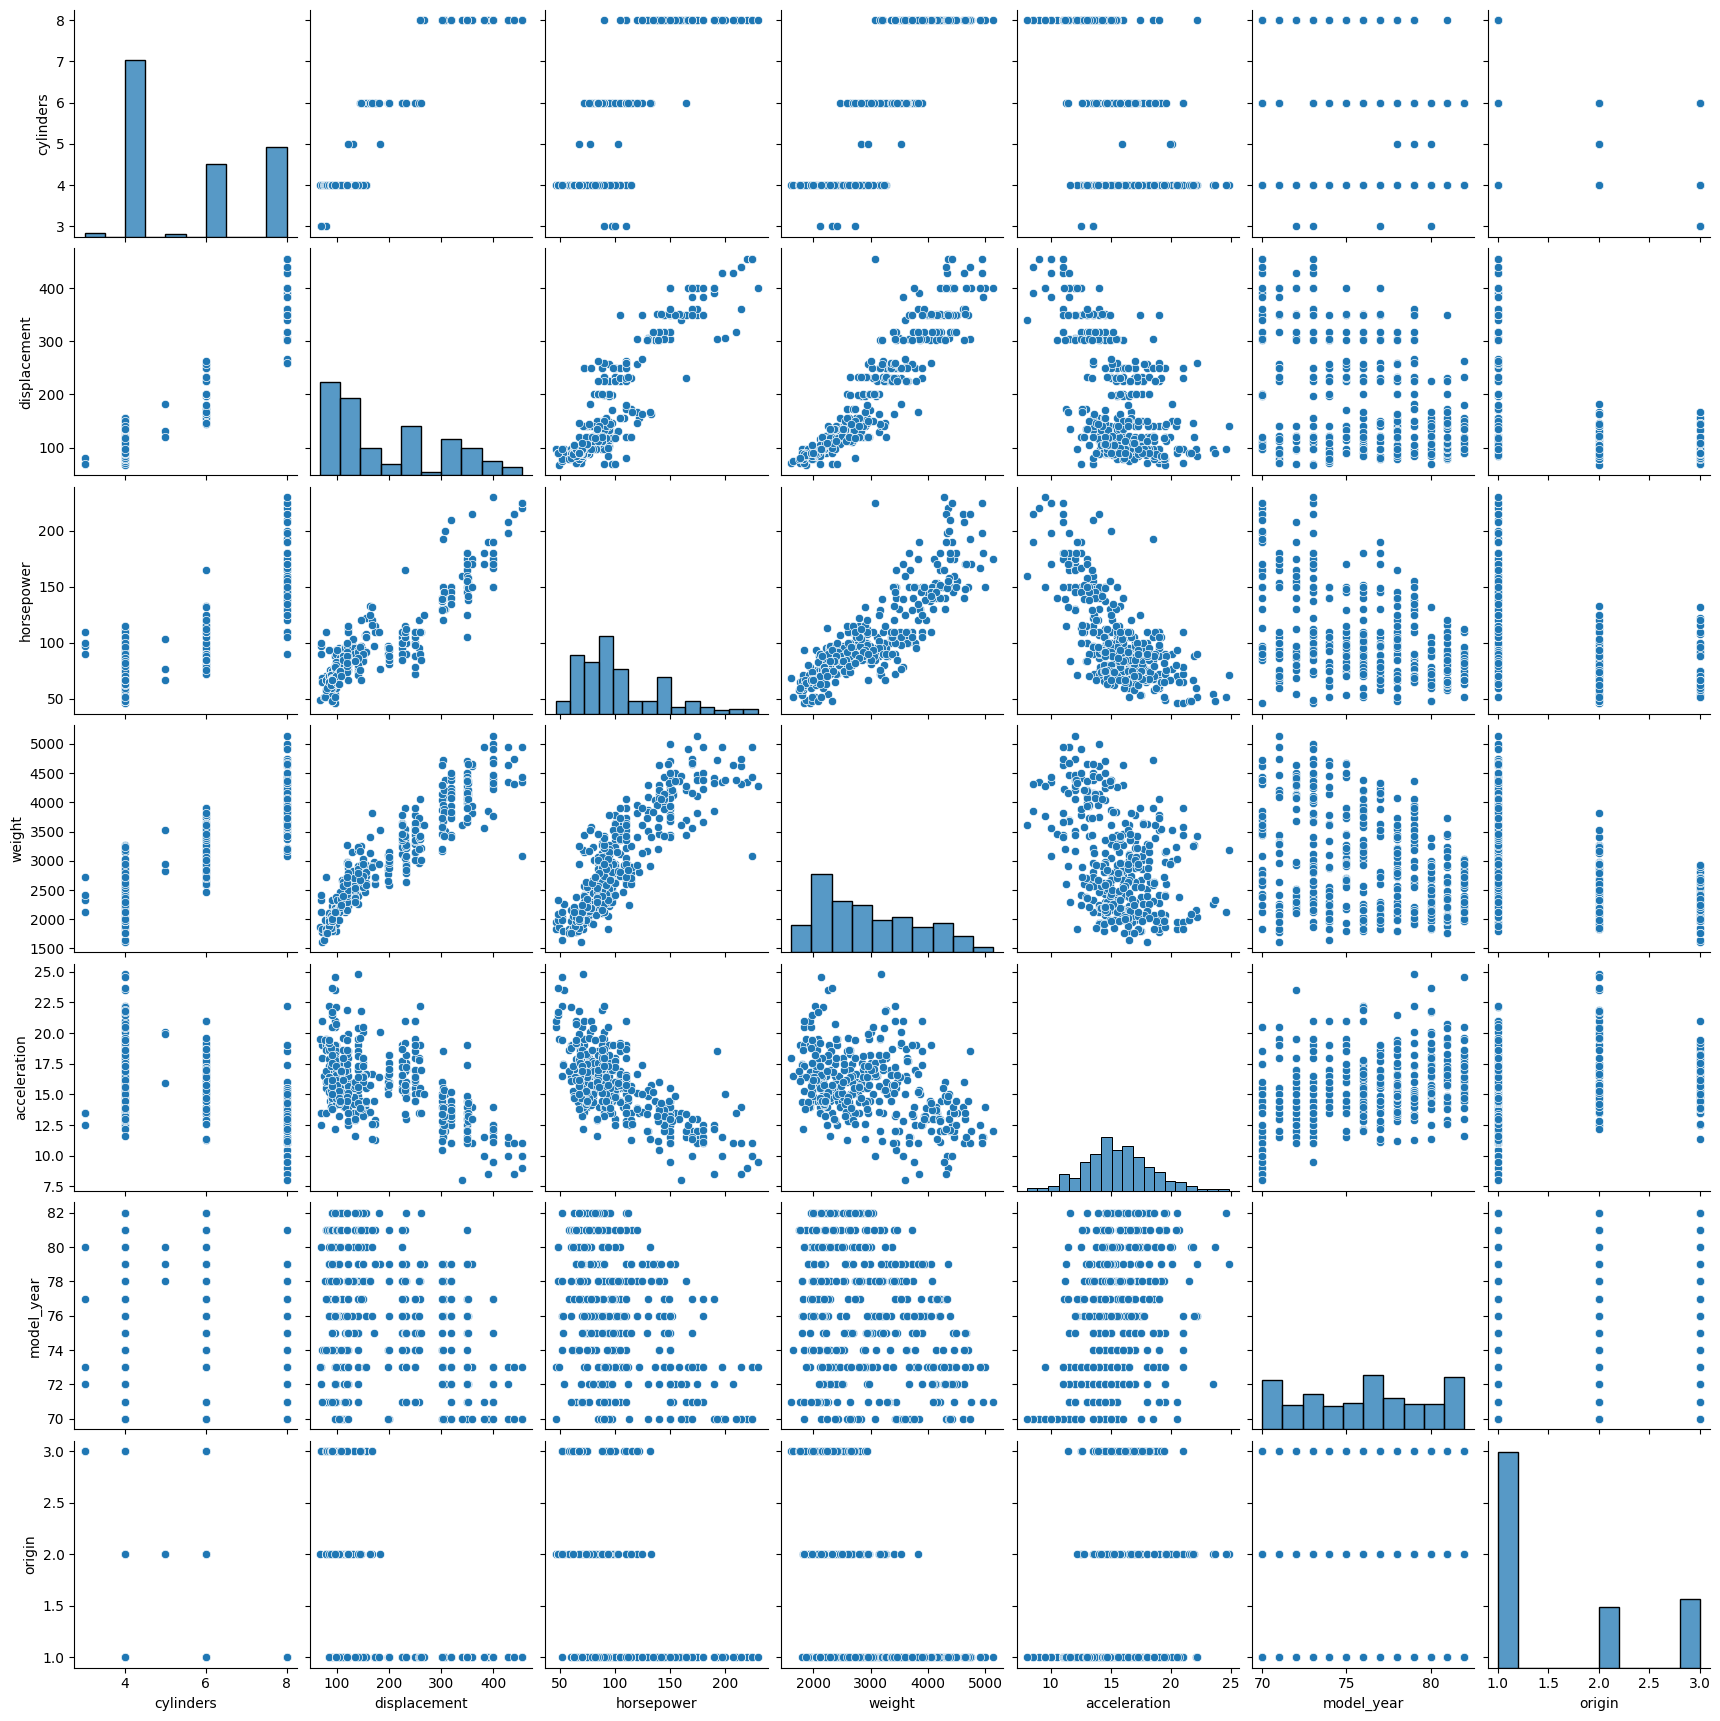

In [7]:
sns.pairplot(data=X_numeric)
plt.show()

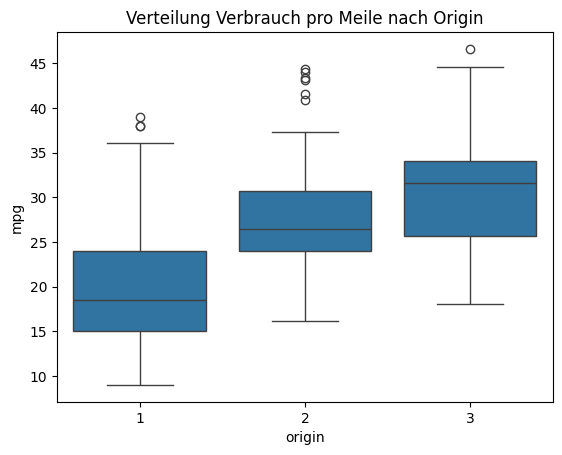

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_2,origin_3
0,8,307.0,130.0,3504,12.0,70,False,False
1,8,350.0,165.0,3693,11.5,70,False,False
2,8,318.0,150.0,3436,11.0,70,False,False
3,8,304.0,150.0,3433,12.0,70,False,False
4,8,302.0,140.0,3449,10.5,70,False,False


In [8]:
# origin column has only three distinct values and it seems that it is categorical data => have to do one-hot-encoding if relevant
sns.boxplot(x=X_numeric['origin'], y=y)
plt.title('Verteilung Verbrauch pro Meile nach Origin')
plt.show()
# origin seems relevant so do one-hot-encoding
origin_data = pd.get_dummies(X_numeric["origin"], drop_first=True, prefix="origin")
X_numeric = pd.concat([X_numeric, origin_data], axis=1).drop("origin", axis=1)
X_numeric.head()

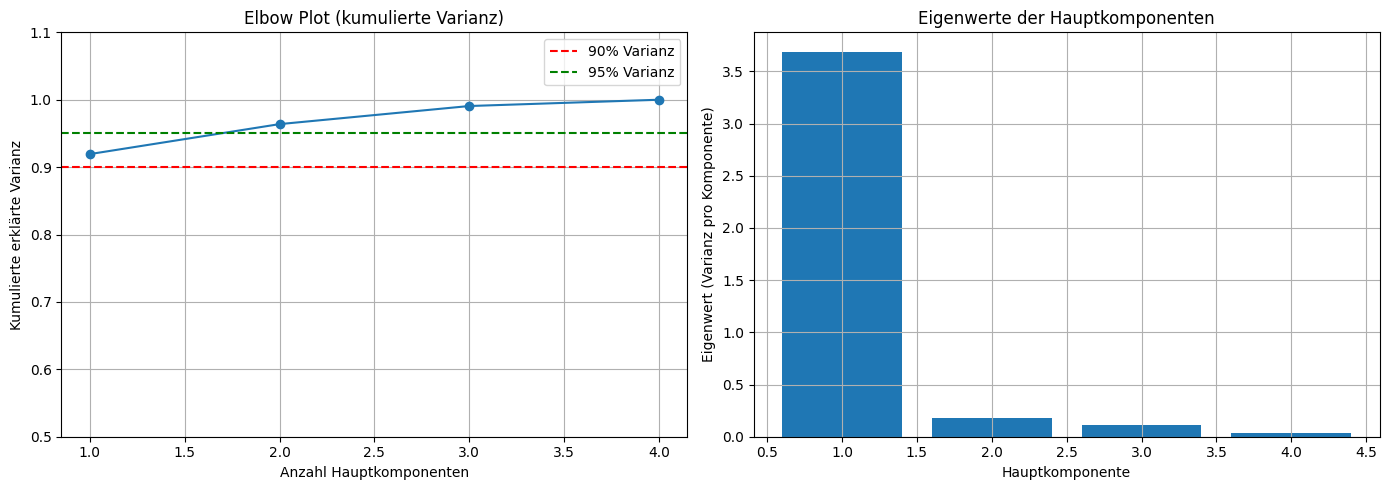

In [9]:
# very high correlation between cylinders, displacement horsepower and weight => use PCA
pca_columns = ["cylinders", "displacement", "horsepower", "weight"]
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[pca_columns])
X_test_scaled = scaler.transform(X_test[pca_columns])
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
eigenvalues = pca.explained_variance_
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
axs[0].axhline(y=0.90, color='r', linestyle='--', label="90% Varianz")
axs[0].axhline(y=0.95, color='g', linestyle='--', label="95% Varianz")
axs[0].set_title("Elbow Plot (kumulierte Varianz)")
axs[0].set_xlabel("Anzahl Hauptkomponenten")
axs[0].set_ylabel("Kumulierte erklärte Varianz")
axs[0].set_ylim(0.5, 1.1)
axs[0].grid(True)
axs[0].legend()

axs[1].bar(range(1, len(eigenvalues)+1), eigenvalues)
axs[1].set_title("Eigenwerte der Hauptkomponenten")
axs[1].set_xlabel("Hauptkomponente")
axs[1].set_ylabel("Eigenwert (Varianz pro Komponente)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
# as seen in the plots above one Principal component already explains 92% of the variance and the eigenvalue of Principal component 2 is
# already so low compared to the eigenvalue of PC 1, that 1 PC is enough
pca_train_df = pd.DataFrame(X_train_pca[:, 0], columns=['PC1'], index=X_train.index)
pca_test_df = pd.DataFrame(X_test_pca[:, 0], columns=['PC1'], index=X_test.index)
X_train_final = pd.concat([pca_train_df, X_train[["acceleration", "model_year", "origin_2", "origin_3"]]], axis=1)
X_test_final = pd.concat([pca_test_df, X_test[["acceleration", "model_year", "origin_2", "origin_3"]]], axis=1)

In [11]:
len(X_train_final.columns)
# 5 features so input layer of neural net has 5 features

5

In [12]:
model = keras.Sequential([
    layers.Input(shape=(5,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(3, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])


In [13]:
history = model.fit(X_train_final, y_train, epochs=150, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 468.2124 - mae: 20.2739 - val_loss: 337.7661 - val_mae: 16.8228
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 284.8133 - mae: 15.0908 - val_loss: 195.7325 - val_mae: 11.9919
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 149.2666 - mae: 9.9411 - val_loss: 87.6053 - val_mae: 7.2224
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.6419 - mae: 6.9662 - val_loss: 43.3408 - val_mae: 5.5896
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.1331 - mae: 5.6577 - val_loss: 43.9359 - val_mae: 5.5780
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.6091 - mae: 5.1587 - val_loss: 42.4173 - val_mae: 5.5590
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.9992 - mae: 5.5627 - val_loss: 37.8637 - val_mae: 5.1880
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.9903 - mae: 5.1553 - val_loss: 35.5054 - val_mae: 5.0538
Epoch 9/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 

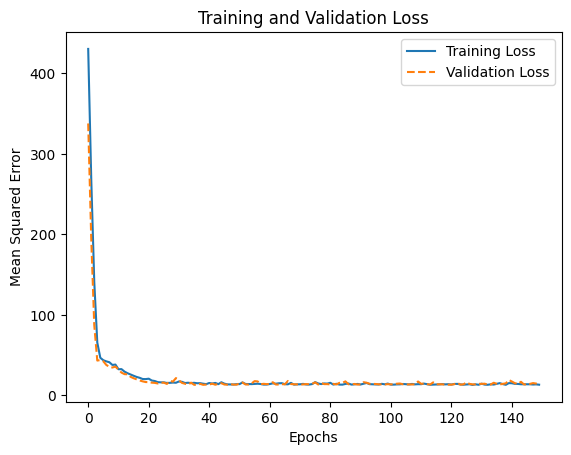

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle="--")
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [20]:
y_pred = model.predict(X_test_final)
test_loss, test_mae = model.evaluate(X_test_final, y_test, verbose=1)
print(f"Test MSE: {test_loss}")
print(f"Test MAE: {test_mae}")
target_range = y.max() - y.min()
normalized_mse = test_loss / (target_range ** 2)
normalized_mae = test_mae / target_range
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"R2: {r2}")
print(f"MAPE: {mape}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5062 - mae: 2.1273 
Test MSE: 8.039911270141602
Test MAE: 2.145063877105713
R2: 0.850466001557483
MAPE: 0.09680833038578437
